# Case de Machine Learning para Live Class FIAP
# Agosto de 2022
## Instrutor: Bruno Curtarelli (Head of Data Science - Petlove & Co)

### Currículo
- Estatística Unicamp
- MBA gestão FIA/PROVAR
- Especializações em Machine Learning e Deep Learning - Andrew Ng (coursera)

### Experiência
- Data Scientist Nielsen
- Head Data Science Behup
- Head Data Science e fundador da área de dados da Petlove em 2018

Atualmente trabalhando com foco em Planejamento e Ressuprimento, desenvolvendo produtos de dados para previsão de demanda e sugestão de compra, além de robôs para monitorar todo o processo e auxiliar na melhoria contínua dos principais indicadores da companhia

Encontro do time de Digital da Petlove & Co

<img src="bruno.jpeg" alt=![bruno.jpeg] align="left" width="700" height="700" />

## Contexto do Problema que veremos hoje: e-commerce / varejista

### Dados disponíveis:
- Transações por cliente, com data, produto, valores

### O que gostaríamos de ter?
- Uma previsão para saber se o cliente vai recomprar e quanto ele deve gastar conosco futuramente
- Uma segmentação dos clientes por nível de gastos e engajamento na nossa loja

### Como usamos isso na prática?
- Otimizar investimentos de marketing
- Customizar campanhas de CRM
- Trabalhar descontos e brindes de maneira inteligente
- Ações de retenção e de atendimento personalizadas

### Pacotes iniciais
Posteriormente importaremos os pacotes para aplicação do método de segmentação de clientes (K-means) e o pacote pare prever gastos futuros dos clientes e probabilidade do cliente estar "vivo" (Lifetimes)

In [70]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Leitura dos dados
Obtidos em: https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis?select=Assignment-1_Data.csv

In [2]:
df = pd.read_csv('transaction_data_example.csv', low_memory=False)

### Descrição dos Dados

- transaction_id: código da transação
- product: descritivo do produto
- quantity: quantidade comprada
- date: timestamp com a data e hora da transação
- price: preço unitário do produto
- customer_id: código de identificação do cliente
- country: país de residência do cliente

In [3]:
df.head()

,transaction_id,product,quantity,date,price,customer_id,country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Com a função "describe" podemos ver a contagem dos campos numéricos e suas distribuições

In [4]:
df.describe()

,quantity,price,customer_id
count,522064.000000,522064.000000,388023.000000
mean,10.090435,3.826801,15316.931710
std,161.110525,41.900599,1721.846964
min,-9600.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13950.000000
50%,3.000000,2.080000,15265.000000
75%,10.000000,4.130000,16837.000000
max,80995.000000,13541.330000,18287.000000


### Com a função "info" podemos ver a tipagem das colunas

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  522064 non-null  object 
 1   product         520609 non-null  object 
 2   quantity        522064 non-null  int64  
 3   date            522064 non-null  object 
 4   price           522064 non-null  float64
 5   customer_id     388023 non-null  float64
 6   country         522064 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 27.9+ MB


## Limpeza de dados faltantes, ajuste de tipos e criação das demais variáveis

### Remoção de clientes e produtos faltantes

In [6]:
df_clean = df.loc[(df['customer_id'].notna()) & (df['product'].notna())].copy()

### Valor total de cada item-pedido
Quantidade x Preço

In [7]:
df_clean['total_value'] = df_clean['quantity']*df_clean['price']

### Ajustes nos tipos de datas e criação da data atual
Como os dados eram antigos, fiz um ajuste nas datas (+10 anos) apenas para trazer mais ao presente

In [8]:
df_clean['date'] = pd.to_datetime(df_clean['date']).dt.date + pd.offsets.DateOffset(years=10)
df_clean['current_date'] = pd.Timestamp.now()

# Análises Descritivas

### TOP 10 Países na base de dados - em número de clientes

### Função para agregação dos dados por países e criação de estatísticas

In [9]:
def country_agg(x):
    names = {
        'transactions': x['transaction_id'].nunique()
        , 'customers': x['customer_id'].nunique()
        , 'total_sales': x['total_value'].sum()
        , 'average_ticket': x['total_value'].sum()/x['transaction_id'].nunique()
        , 'distinct_products': x['product'].nunique()
        , 'total_quantity': x['quantity'].sum()
        , 'average_products_per_transaction': x['product'].count()/x['transaction_id'].nunique()
        , 'average_quantity': x['quantity'].sum()/x['transaction_id'].nunique()
    }
    return pd.Series(names, index=['transactions'
                                  , 'customers'
                                  , 'total_sales'
                                  , 'average_ticket'
                                  , 'distinct_products'
                                  , 'total_quantity'
                                  , 'average_products_per_transaction'
                                  , 'average_quantity'
                                  ])

## Podemos notar que a maior parte das transações estão no Reino Unido
- Suiça é o pais com maior ticket médio e maior número de produtos por pedido
- Espanha e Italia são os países de menor ticket e produtos por pedido

In [10]:
top_countries = df_clean.groupby('country').apply(country_agg).sort_values('customers', ascending=False)
top_countries['customer_percent'] = top_countries['customers']/top_countries['customers'].sum()*100
top_countries.head(10)

,transactions,customers,total_sales,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,customer_percent
country,,,,,,,,,
United Kingdom,16649.0,3921.0,7308391.554,438.968800,3833.0,4269472.0,21.283260,256.440147,91.186047
Germany,457.0,94.0,228867.140,500.803370,1695.0,119263.0,19.785558,260.969365,2.186047
France,389.0,87.0,209024.050,537.336889,1543.0,111472.0,21.444730,286.560411,2.023256
Spain,90.0,30.0,61577.110,684.190111,1104.0,27951.0,27.611111,310.566667,0.697674
Belgium,98.0,25.0,41196.340,420.370816,784.0,23237.0,20.724490,237.112245,0.581395
Switzerland,51.0,21.0,56443.950,1106.744118,954.0,30083.0,36.117647,589.862745,0.488372
Portugal,57.0,19.0,33439.890,586.664737,693.0,16122.0,25.649123,282.842105,0.441860
Italy,38.0,14.0,17483.240,460.085263,476.0,8112.0,19.947368,213.473684,0.325581
Austria,17.0,11.0,10198.680,599.922353,306.0,4881.0,23.411765,287.117647,0.255814


## Análises de clientes

### Função para agregação dos dados por clientes e criação de estatísticas

In [11]:
def custom_agg(x):
    names = {
        'transactions': x['transaction_id'].nunique()
        , 'countries': x['country'].nunique()
        , 'total_spent': x['total_value'].sum()
        , 'average_ticket': x['total_value'].sum()/x['transaction_id'].nunique()
        , 'distinct_products': x['product'].nunique()
        , 'total_quantity': x['quantity'].sum()
        , 'average_products_per_transaction': x['product'].count()/x['transaction_id'].nunique()
        , 'average_quantity': x['quantity'].sum()/x['transaction_id'].nunique()
        , 'recency': (x['current_date'].max() - x['date'].max())/np.timedelta64(1,'D')  
        , 'time': (x['date'].max() - x['date'].min())/np.timedelta64(1,'D')  
    }
    return pd.Series(names, index=['transactions'
                                  , 'countries'
                                  , 'total_spent'
                                  , 'average_ticket'
                                  , 'distinct_products'
                                  , 'total_quantity'
                                  , 'average_products_per_transaction'
                                  , 'average_quantity'
                                  , 'recency'
                                  , 'time'])

### Dataset com os indicadores agregados por clientes

In [12]:
customers = df_clean.groupby('customer_id').apply(custom_agg).reset_index()

### Criação do tempo médio entre pedidos
- No caso do cliente ter 1 pedido, colocamos 9999 (para penalizar essa variável)
- Do contrário, o tempo médio entre pedidos é o tempo entre o primeiro e o útimo pedido dividido pelo total de transações menos 1

In [13]:
customers['average_time_between_orders'] = np.where(customers['time']<0.001, 9999, customers['time']/(customers['transactions']-1))

In [14]:
customers.head()

,customer_id,transactions,countries,total_spent,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,recency,time,average_time_between_orders
0,12346.0,1.0,1.0,77183.60,77183.600000,1.0,74215.0,1.000,74215.000000,587.695364,0.0,9999.000000
1,12347.0,7.0,1.0,4310.00,615.714286,103.0,2458.0,26.000,351.142857,264.695364,365.0,60.833333
2,12349.0,1.0,1.0,1757.55,1757.550000,73.0,631.0,73.000,631.000000,280.695364,0.0,9999.000000
3,12350.0,1.0,1.0,334.40,334.400000,17.0,197.0,17.000,197.000000,572.695364,0.0,9999.000000
4,12352.0,8.0,1.0,2506.04,313.255000,59.0,536.0,10.625,67.000000,298.695364,260.0,37.142857


### Somente 3 Clientes possuem compras em mais de 1 País

In [15]:
customers.loc[customers['countries']>1, 'customer_id'].nunique()

3

### Distribuição de clientes de acordo com a quantidade de transações
- A maioria dos clientes possuem poucas transações

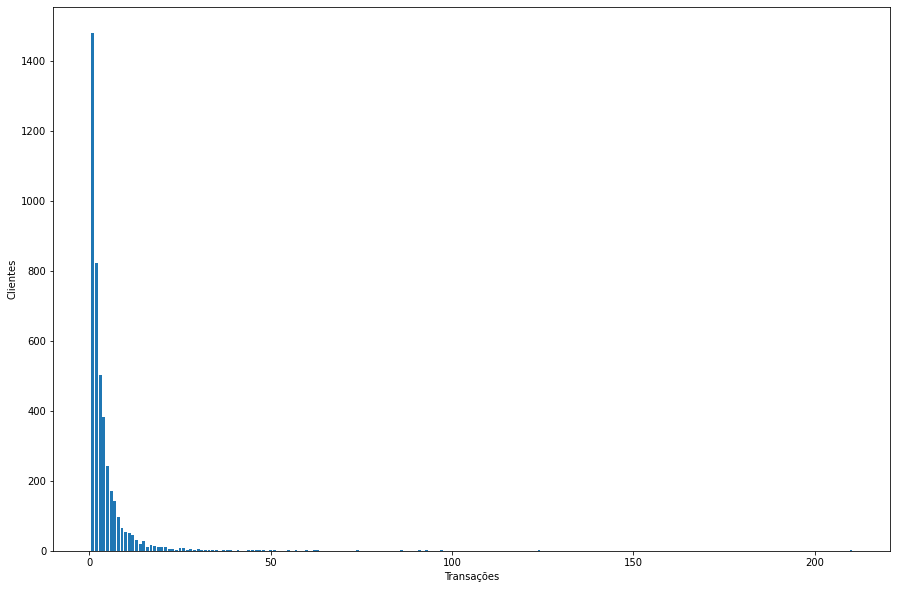

In [16]:
dist_transactions = customers.groupby('transactions').nunique()[['customer_id']].reset_index()
plt.figure(figsize=(15,10))
plt.bar(dist_transactions['transactions'], dist_transactions['customer_id'])
plt.xlabel('Transações')
plt.ylabel('Clientes')
plt.show()

### Fazendo um "zoom" na distribuição, cortando clientes com número de transações muito elevado

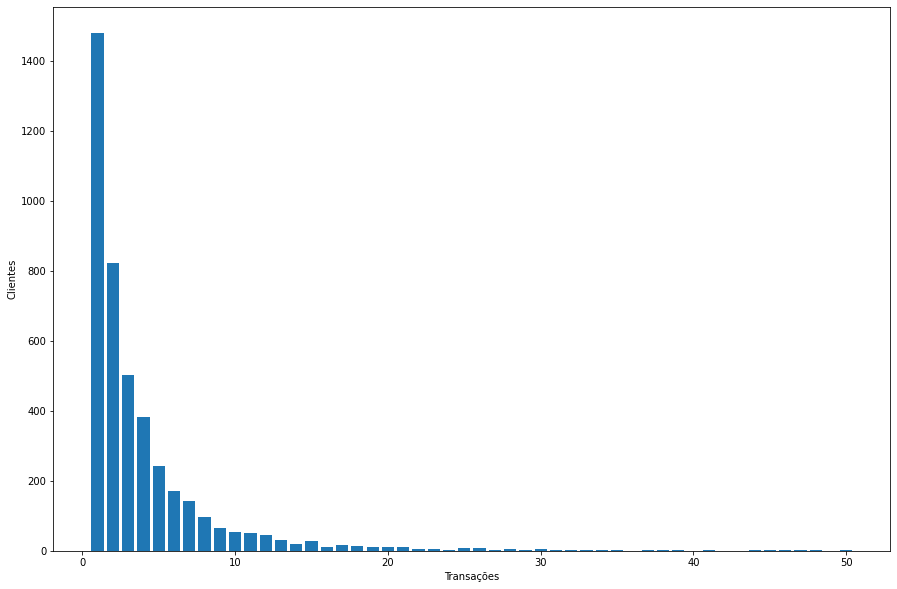

In [17]:
dist_transactions = customers.groupby('transactions').nunique()[['customer_id']].reset_index()
plt.figure(figsize=(15,10))
plt.bar(dist_transactions.loc[dist_transactions['transactions']<=50, 'transactions'], dist_transactions.loc[dist_transactions['transactions']<=50, 'customer_id'])
plt.xlabel('Transações')
plt.ylabel('Clientes')
plt.show()

### Criação de faixas mais agregadas

In [18]:
col = 'transactions'
conditions = [customers[col] == 1
              , (customers[col] > 1) & (customers[col] <= 5)
              , (customers[col] > 5) & (customers[col] <= 10)
              , customers[col] > 10]
choices = ['1. Unique Order'
           , '2. Between 2-5 Orders'
           , '3. Between 6-10 Orders' 
           , '4. More than 10 Orders' ]
    
customers['transaction_frequency'] = np.select(conditions, choices, default=np.nan)

In [19]:
def customers_agg(x):
    names = {
        'customers': x['customer_id'].nunique()
        , 'average_distinct_products': x['distinct_products'].sum()/x['transactions'].sum()
        , 'total_quantity': x['total_quantity'].sum()
        , 'average_quantity': x['total_quantity'].sum()/x['transactions'].sum()
        , 'total_spent': x['total_spent'].sum()
        , 'average_ticket': x['total_spent'].sum()/x['transactions'].sum()
        , 'average_time_between_orders': x['time'].sum()/(x['transactions'].sum()-x['customer_id'].nunique())
        , 'transactions_per_customer': x['transactions'].sum()/x['customer_id'].nunique()
        , 'average_recency': x['recency'].sum()/x['customer_id'].nunique()
    }
    return pd.Series(names, index=['customers'
                                  , 'average_distinct_products'
                                  , 'total_quantity'
                                  , 'average_quantity'
                                  , 'total_spent'
                                  , 'average_ticket'
                                  , 'average_time_between_orders'
                                  , 'transactions_per_customer'
                                  , 'average_recency'
                                  ])

### Alavancas de engajamento e valor:
- recency: recência ou quanto tempo faz desde a última compra
- transactions: número total de pedidos que o cliente já fez
- averag_ticket: gasto médio por pedido
- average_time_between_orders: frequência de compra ou tempo médio em dias, entre os pedidos

Clientes mais engajados, com mais pedidos e menor tempo entre pedidos também possuem maior ticket médio

In [20]:
customers.groupby('transaction_frequency').apply(customers_agg)

/tmp/ipykernel_18136/640007857.py:9: RuntimeWarning: invalid value encountered in double_scalars
  , 'average_time_between_orders': x['time'].sum()/(x['transactions'].sum()-x['customer_id'].nunique())


,customers,average_distinct_products,total_quantity,average_quantity,total_spent,average_ticket,average_time_between_orders,transactions_per_customer,average_recency
transaction_frequency,,,,,,,,,
1. Unique Order,1481.0,21.657664,413018.0,278.877785,607958.561,410.505443,NaN,1.000000,419.307113
2. Between 2-5 Orders,1952.0,18.615424,1352608.0,229.255593,2340022.773,396.614029,78.445289,3.022541,335.554995
3. Between 6-10 Orders,529.0,15.189954,899451.0,229.334778,1486894.540,379.116405,42.015326,7.413989,293.943001
4. More than 10 Orders,335.0,9.006706,2337370.0,340.724490,4129650.520,601.989872,16.796169,20.477612,278.277453


### Distribuição do Ticket Médio

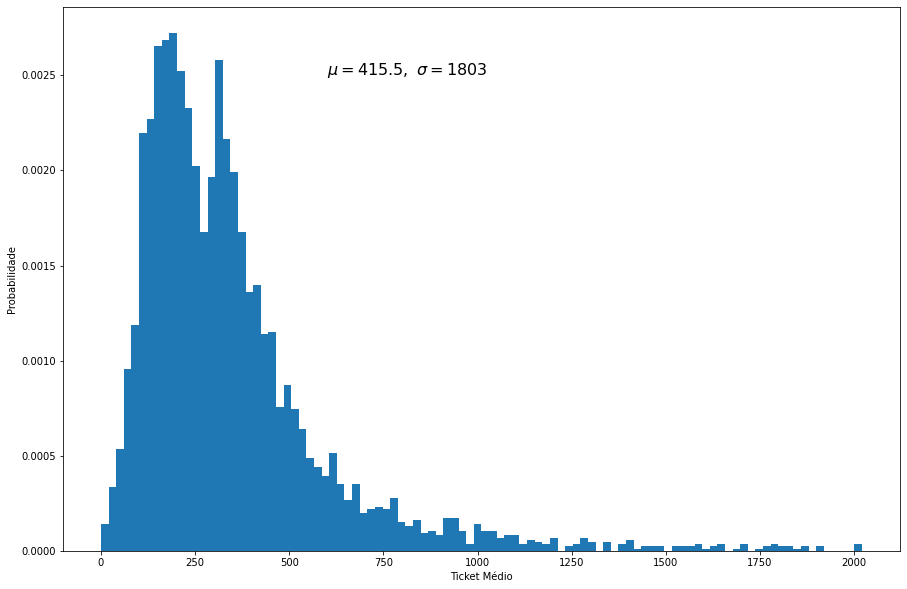

In [21]:
ol = customers.quantile(.99)['average_ticket']
media = round(customers[['average_ticket']].mean().values[0],1)
desvio = round(customers[['average_ticket']].std().values[0],)
plt.figure(figsize=(15,10))
plt.hist(customers.loc[customers['average_ticket']<=ol, 'average_ticket'], 100, density=True)
plt.xlabel('Ticket Médio')
plt.ylabel('Probabilidade')
plt.text(600, .0025, f'$\mu={media},\ \sigma={desvio}$', fontsize=16)
plt.show()

### Distribuição da Recência

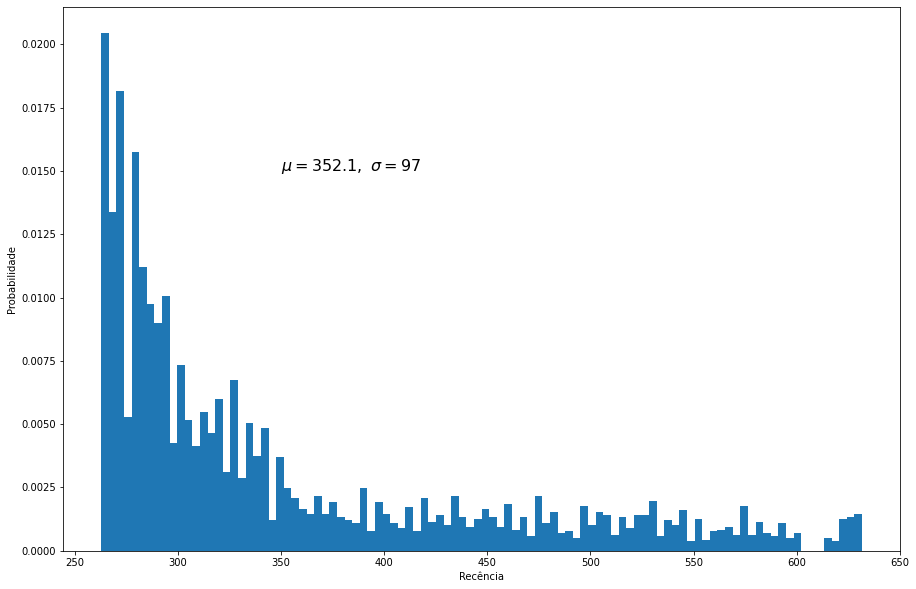

In [22]:
ol = customers.quantile(.99)['recency']
media = round(customers.loc[customers['recency']<=ol, ['recency']].mean().values[0],1)
desvio = round(customers.loc[customers['recency']<=ol, ['recency']].std().values[0],)
plt.figure(figsize=(15,10))
plt.hist(customers.loc[customers['recency']<=ol, 'recency'], 100, density=True)
plt.xlabel('Recência')
plt.ylabel('Probabilidade')
plt.text(350, .015, f'$\mu={media},\ \sigma={desvio}$', fontsize=16)
plt.show()

### Distribuição do tempo médio entre pedidos

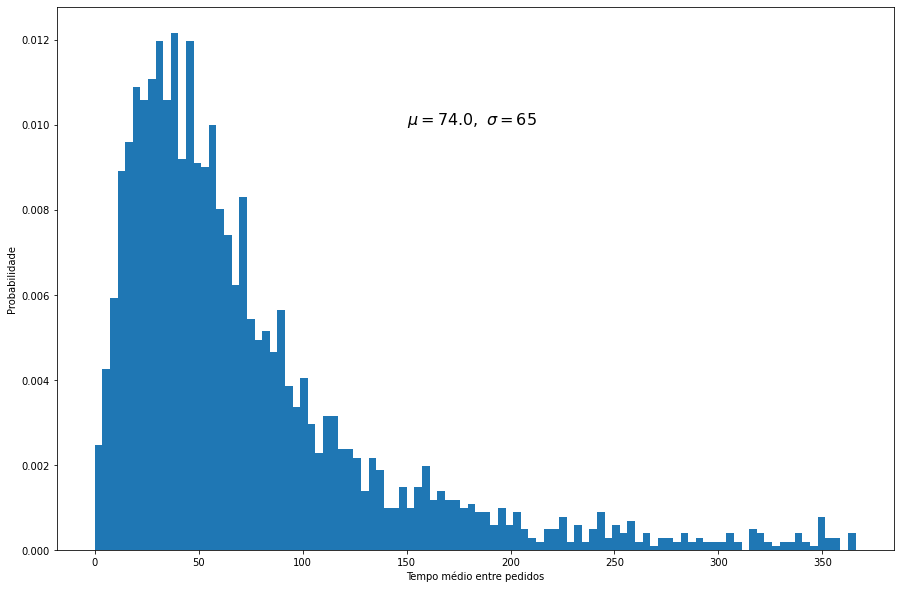

In [23]:
media = round(customers.loc[customers['average_time_between_orders']<9999, ['average_time_between_orders']].mean().values[0],1)
desvio = round(customers.loc[customers['average_time_between_orders']<9999, ['average_time_between_orders']].std().values[0],)
plt.figure(figsize=(15,10))
plt.hist(customers.loc[customers['average_time_between_orders']<9999, 'average_time_between_orders'], 100, density=True)
plt.xlabel('Tempo médio entre pedidos')
plt.ylabel('Probabilidade')
plt.text(150, .01, f'$\mu={media},\ \sigma={desvio}$', fontsize=16)
plt.show()

# Segmentação de Clientes usando RFV

## Recência, Frequência, Valor, +Quantidade de Pedidos

### Técnicas utilizadas:
**K-Means Clustering:** Método de aprendizado não supervisionado
O método de clusterização K Means busca alocar as amostras em grupos (clusters) mais homogêneos possíveis e heterogêneos entre si.
Ele funciona assim:
- Primeiro é feita a definição do número de clusters que queremos segmentar nossos dados
- Depois são defindos os centróides (podem ser pontos aleatórios no espaço dos dados, ou pontos de amostras aleatórias, ou pontos pré-definidos). Os centróides são os pontos de referência com os quais vamos calcular as distâncias de cada amostra até eles
- As amostras são associadas aos centróides mais próximos e novos centróides são definidos com base nas amostras que ficaram num mesmo grupo
- O algoritmo vai iterando até que nenhuma amostra seja realocada, ou até um número pré-definido de iterações

fonte: https://www.nickmccullum.com/images/python-machine-learning/introduction-k-means-clustering/k-means-iteration.gif
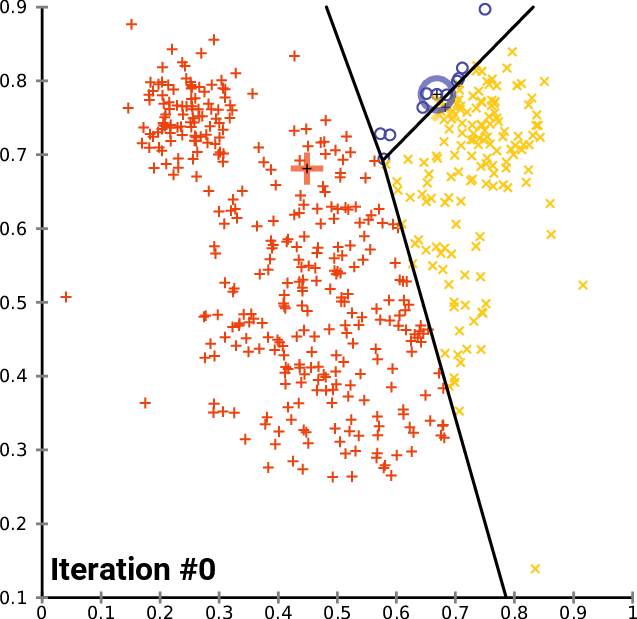

### Vamos usar o módulo scikit-learn para aplicar este algoritmo
https://scikit-learn.org/stable/

In [24]:
from sklearn.cluster import KMeans

### Primeiramente vamos aplicar o "método do cotovelo" para determinar o número de clusters para cada variável

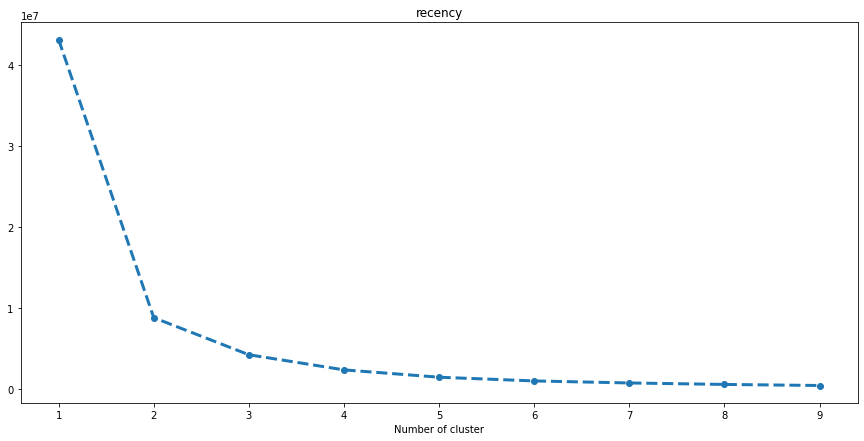

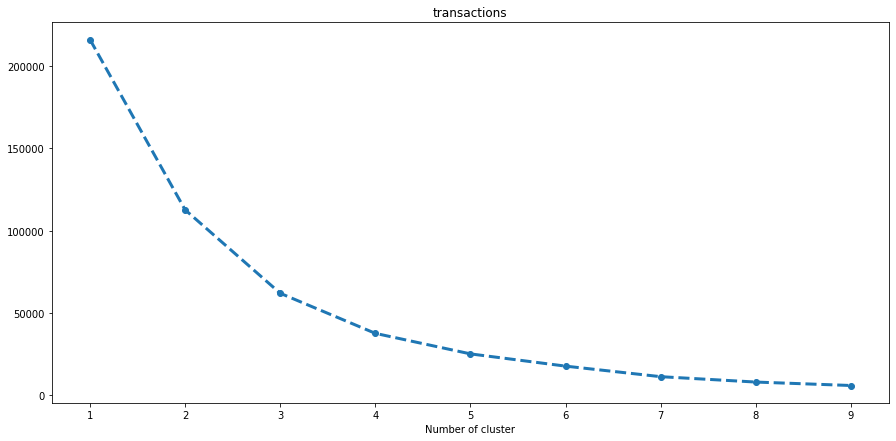

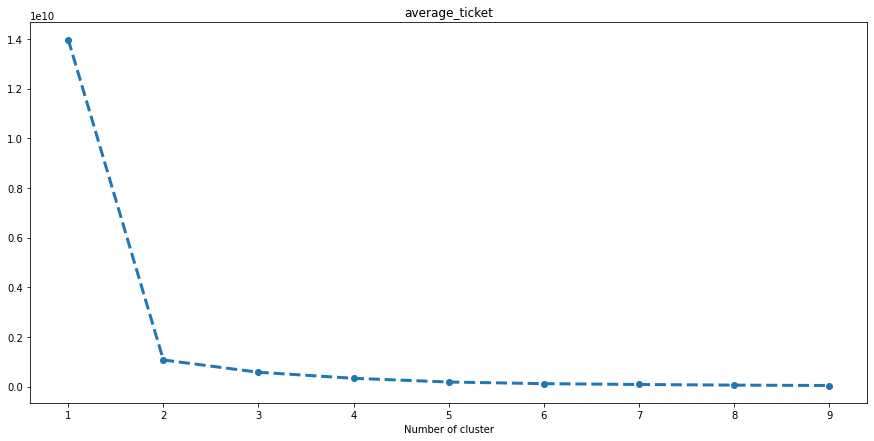

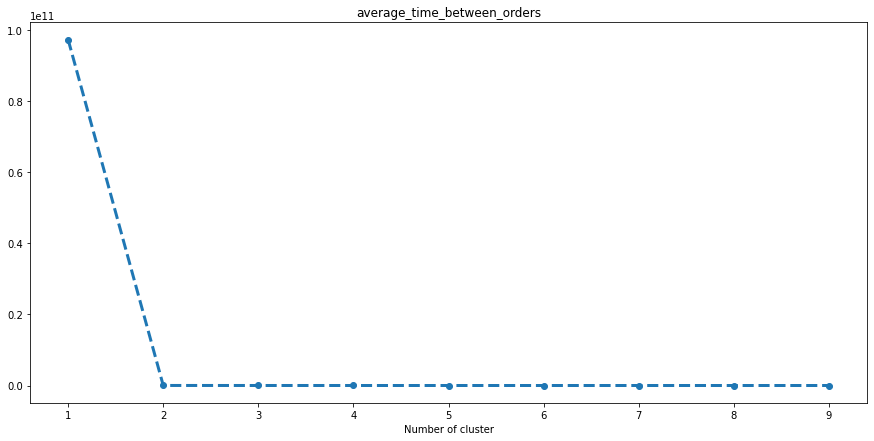

In [25]:
for cols in ['recency', 'transactions', 'average_ticket', 'average_time_between_orders']:
    sse={}
    clus = customers[[cols]].copy()
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(clus)
        clus["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure(figsize=(15,7))
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=3,linestyle='--', marker='o')
    plt.xlabel("Number of cluster")
    plt.title(cols)
    plt.show()

### Criando uma função para ordernar o número dos clusters de acordo com o sentido de cada variável
Exemplos:
- ticket médio, quanto maior melhor, então os clientes de maior ticket ficam no cluster de maior número e os de menor ticket ficam no grupo zero
- tempo entre pedidos, quanto menor melhor, então os clientes com maior tempo médio ficam no grupo zero e o de menor tempo ficam no grupo de maior número

In [26]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

### Dicionários com número de clusters por variável e sentido para ordenação

In [27]:
dict_clusters = {'recency':3, 'transactions':4, 'average_ticket':2, 'average_time_between_orders':2}
dict_sort = {'recency':False, 'transactions':True, 'average_ticket':True, 'average_time_between_orders':False}

### Aplicando o K-Means em cada variável

In [28]:
for m in dict_clusters.keys():
    kmeans = KMeans(n_clusters=dict_clusters[m])
    kmeans.fit(customers[[m]])

    customers[m+'_cluster'] = kmeans.predict(customers[[m]])
    
    customers = order_cluster(m+'_cluster', m, customers, dict_sort[m])

### Criando o score geral de cada cliente

In [29]:
customers['OverallScore'] = customers['recency_cluster'] + \
                              customers['transactions_cluster'] + \
                              customers['average_ticket_cluster'] +\
                              customers['average_time_between_orders_cluster']

### Base com todas variáveis por cliente, classificação de cluster de cada variável e scoragem final

In [30]:
customers

,customer_id,transactions,countries,total_spent,average_ticket,distinct_products,total_quantity,average_products_per_transaction,average_quantity,recency,time,average_time_between_orders,transaction_frequency,recency_cluster,transactions_cluster,average_ticket_cluster,average_time_between_orders_cluster,OverallScore
0,12346.0,1.0,1.0,77183.60,77183.600000,1.0,74215.0,1.000000,74215.000000,587.695364,0.0,9999.000000,1. Unique Order,0,0,1,0,1
1,12350.0,1.0,1.0,334.40,334.400000,17.0,197.0,17.000000,197.000000,572.695364,0.0,9999.000000,1. Unique Order,0,0,0,0,0
2,12354.0,1.0,1.0,1079.40,1079.400000,58.0,530.0,58.000000,530.000000,494.695364,0.0,9999.000000,1. Unique Order,0,0,0,0,0
3,12361.0,1.0,1.0,189.90,189.900000,10.0,91.0,10.000000,91.000000,549.695364,0.0,9999.000000,1. Unique Order,0,0,0,0,0
4,12370.0,1.0,1.0,277.20,277.200000,8.0,51.0,8.000000,51.000000,619.695364,0.0,9999.000000,1. Unique Order,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4292,13089.0,97.0,1.0,58825.83,606.451856,662.0,31070.0,18.742268,320.309278,264.695364,367.0,3.822917,4. More than 10 Orders,2,3,0,1,6
4293,14606.0,93.0,1.0,12156.65,130.716667,825.0,6224.0,29.032258,66.924731,263.695364,372.0,4.043478,4. More than 10 Orders,2,3,0,1,6
4294,14646.0,74.0,1.0,280206.02,3786.567838,719.0,197491.0,28.108108,2668.797297,263.695364,353.0,4.835616,4. More than 10 Orders,2,3,0,1,6
4295,15311.0,91.0,1.0,60767.90,667.779121,576.0,38194.0,26.142857,419.714286,262.695364,373.0,4.144444,4. More than 10 Orders,2,3,0,1,6


### Resumo da base de clientes, agregando por Score Geral

In [31]:
customers.groupby('OverallScore').apply(customers_agg)

,customers,average_distinct_products,total_quantity,average_quantity,total_spent,average_ticket,average_time_between_orders,transactions_per_customer,average_recency
OverallScore,,,,,,,,,
0,510.0,18.697318,85545.0,163.879310,157075.020,300.910000,0.000000,1.023529,560.199285
1,463.0,17.126761,222897.0,348.821596,380786.310,595.909718,35.414773,1.380130,450.729921
2,1091.0,18.503345,438053.0,225.451879,680271.192,350.113840,64.983568,1.780935,347.846601
3,1559.0,18.585738,1246352.0,226.157140,2050399.922,372.055874,74.091599,3.534958,296.551040
4,582.0,13.299216,1559562.0,254.580803,2774131.840,452.845550,31.575397,10.525773,281.494333
5,85.0,6.316207,1118951.0,422.724216,2024004.500,764.640914,11.636612,31.141176,268.542423
6,7.0,7.735484,331087.0,427.209032,497857.610,642.396916,3.358073,110.714286,263.838221


## Avaliando os grupos por distribuição das variáveis usadas nos clusters

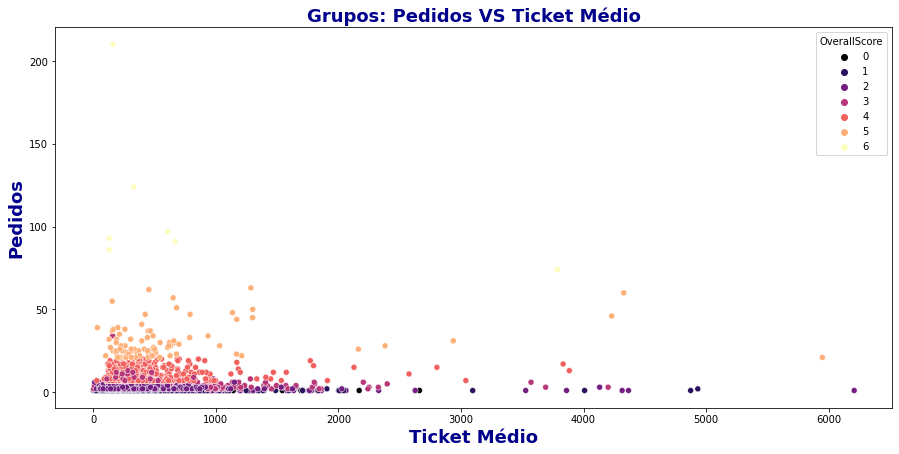

In [80]:
plt.figure(figsize=(15,7));
sns.scatterplot(data=customers.loc[customers['average_ticket']<10000], x='average_ticket', y='transactions', hue = 'OverallScore', palette='magma');
plt.title("Grupos: Pedidos VS Ticket Médio", fontsize=18, fontweight='bold',color='darkblue');
plt.xlabel('Ticket Médio',fontsize=18,fontweight='bold',color='darkblue');
plt.ylabel('Pedidos',fontsize=18,fontweight='bold',color='darkblue');
plt.show()

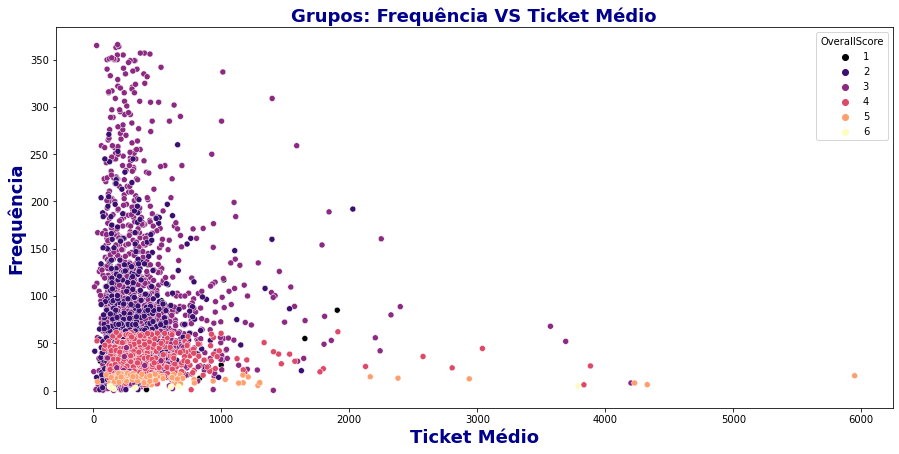

In [82]:
plt.figure(figsize=(15,7));
sns.scatterplot(data=customers.loc[(customers['average_ticket']<10000) & (customers['average_time_between_orders']<1000)], x='average_ticket', y='average_time_between_orders', hue = 'OverallScore', palette='magma');
plt.title("Grupos: Frequência VS Ticket Médio", fontsize=18, fontweight='bold',color='darkblue');
plt.xlabel('Ticket Médio',fontsize=18,fontweight='bold',color='darkblue');
plt.ylabel('Frequência',fontsize=18,fontweight='bold',color='darkblue');
plt.show()

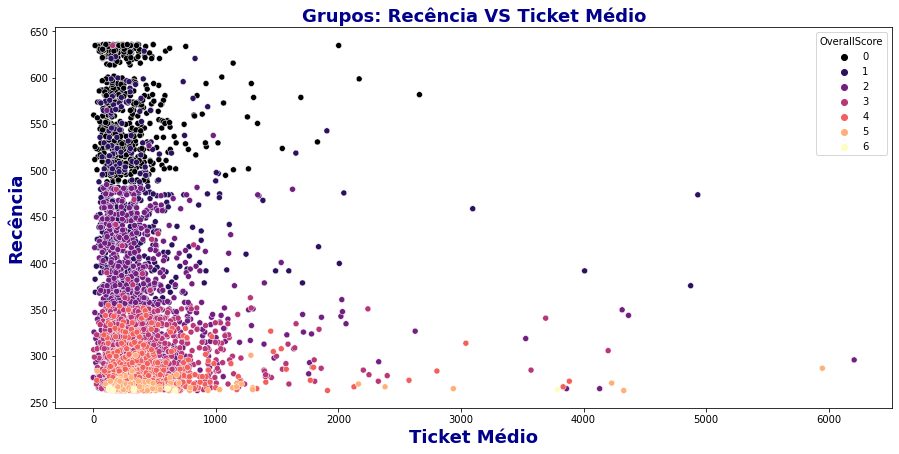

In [92]:
plt.figure(figsize=(15,7));
sns.scatterplot(data=customers.loc[(customers['average_ticket']<10000) ], x='average_ticket', y='recency', hue = 'OverallScore', palette='magma');
plt.title("Grupos: Recência VS Ticket Médio", fontsize=18, fontweight='bold',color='darkblue');
plt.xlabel('Ticket Médio',fontsize=18,fontweight='bold',color='darkblue');
plt.ylabel('Recência',fontsize=18,fontweight='bold',color='darkblue');
plt.show()

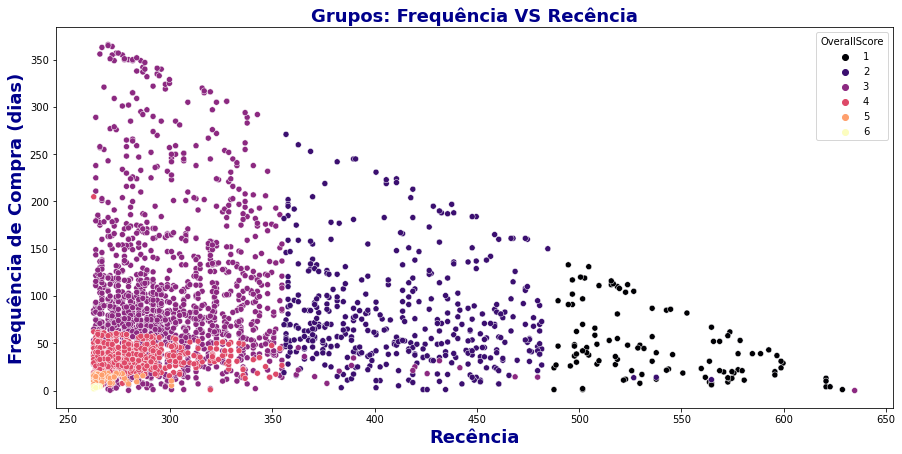

In [88]:
plt.figure(figsize=(15,7));
sns.scatterplot(data=customers.loc[customers['average_time_between_orders']!=9999], x='recency', y='average_time_between_orders', hue = 'OverallScore', palette='magma');
plt.title("Grupos: Frequência VS Recência", fontsize=18, fontweight='bold',color='darkblue');
plt.xlabel('Recência',fontsize=18,fontweight='bold',color='darkblue');
plt.ylabel('Frequência de Compra (dias)',fontsize=18,fontweight='bold',color='darkblue');
plt.show()

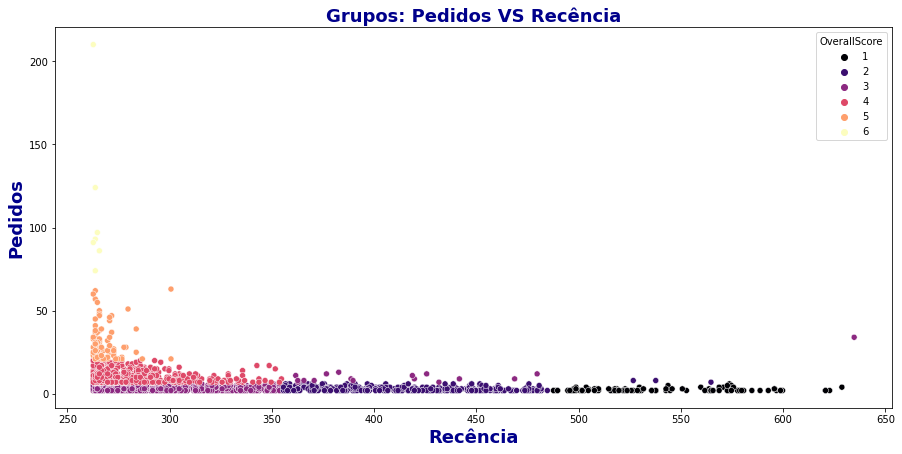

In [89]:
plt.figure(figsize=(15,7));
sns.scatterplot(data=customers.loc[customers['average_time_between_orders']!=9999], x='recency', y='transactions', hue = 'OverallScore', palette='magma');
plt.title("Grupos: Pedidos VS Recência", fontsize=18, fontweight='bold',color='darkblue');
plt.xlabel('Recência',fontsize=18,fontweight='bold',color='darkblue');
plt.ylabel('Pedidos',fontsize=18,fontweight='bold',color='darkblue');
plt.show()

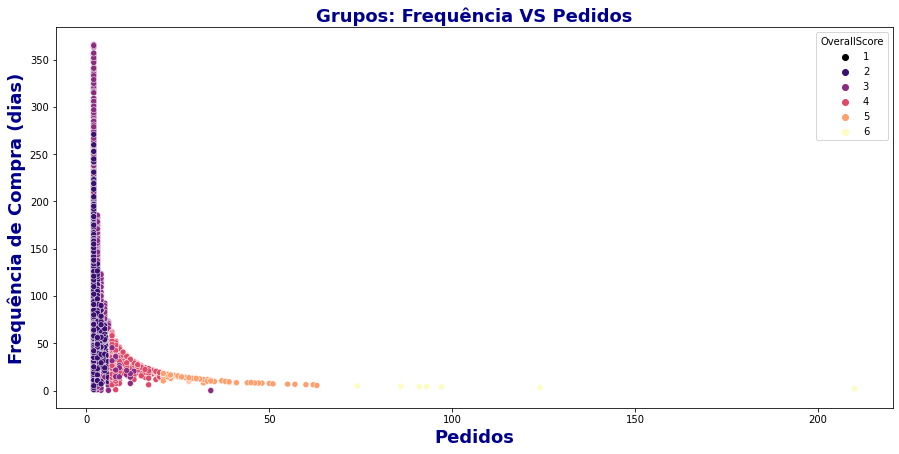

In [90]:
plt.figure(figsize=(15,7));
sns.scatterplot(data=customers.loc[customers['average_time_between_orders']!=9999], x='transactions', y='average_time_between_orders', hue = 'OverallScore', palette='magma');
plt.title("Grupos: Frequência VS Pedidos", fontsize=18, fontweight='bold',color='darkblue');
plt.xlabel('Pedidos',fontsize=18,fontweight='bold',color='darkblue');
plt.ylabel('Frequência de Compra (dias)',fontsize=18,fontweight='bold',color='darkblue');
plt.show()

# Agora é mostrar os resultados para os times de Marketing, CRM, Atendimento e discutir as ações!

### Para que clientes poderíamos fazer campanhas de reativação?
### Quais clientes quero nutrir e engajar com melhores brindes?
### Quanto estamos dispostos a gastar para reter um cliente super engajado e valoroso?

## Uma abordagem alternativa:
### Segmentar usando todas as variáveis conjuntamente

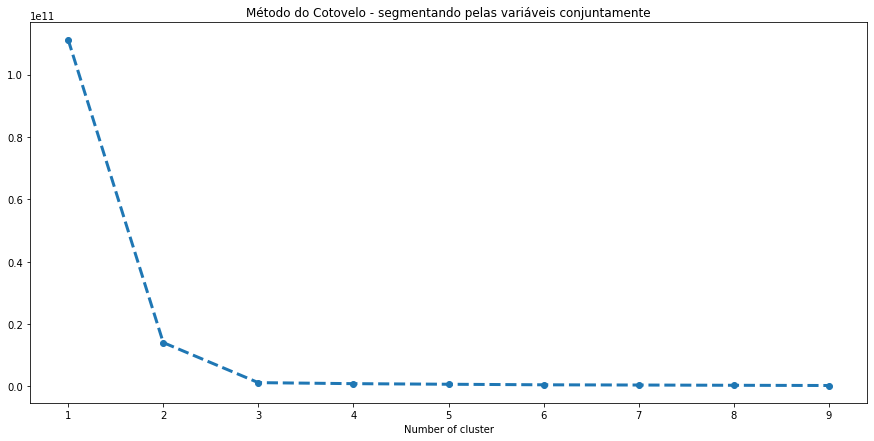

In [32]:
base_cluster = customers[['recency', 'transactions', 'average_ticket', 'average_time_between_orders']].copy()
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster)
    base_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure(figsize=(15,7))
plt.plot(list(sse.keys()), list(sse.values()), linewidth=3,linestyle='--', marker='o')
plt.xlabel("Number of cluster")
plt.title("Método do Cotovelo - segmentando pelas variáveis conjuntamente")
plt.show()

### Aplicando o K-Means para as 4 variáveis juntas, segmentando em 3 grupos

In [33]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(customers[['recency', 'transactions', 'average_ticket', 'average_time_between_orders']])
customers['cluster_variaveis_conjuntas'] = kmeans.predict(customers[['recency', 'transactions', 'average_ticket', 'average_time_between_orders']])

### Resultado dos clusters agregados

In [34]:
customers.groupby('cluster_variaveis_conjuntas').apply(customers_agg)

,customers,average_distinct_products,total_quantity,average_quantity,total_spent,average_ticket,average_time_between_orders,transactions_per_customer,average_recency
cluster_variaveis_conjuntas,,,,,,,,,
0,2761.0,13.822216,4483344.0,270.651615,7700306.823,464.854019,40.687482,5.999638,319.415393
1,1534.0,21.503448,363891.0,228.144828,618563.471,387.814088,0.000000,1.039765,418.487411
2,2.0,1.333333,155212.0,51737.333333,245656.100,81885.366667,205.000000,1.500000,425.195364


# Explorando o módulo Lifetimes

### O lifetimes é uma biblioteca que permite medir clientes de maneira mais simplificada, pois ela já possui as funções para estimar a probabilidade de um cliente estar "vivo" (voltar a comprar) e quanto esse cliente deve gastar num horizonte de tempo futuro

A documentação completa desta biblioteca pode ser encontrada aqui:
https://lifetimes.readthedocs.io/en/latest/index.html

E a documentação do módulo no pip está aqui:
https://pypi.org/project/Lifetimes/

Para usar o Lifetimes precisamos fazer algumas pequenas adaptações nas variáveis que vamos usar.

- frequencia = número de recompras (total de pedidos menos 1)
- T = idade do cliente (tempo entre o primeiro pedido e a data de hoje)
- recencia = tempo entre primeiro e o último pedido (clientes com 1 pedido tem zero de recência)
- valor monetario = gasto médio do cliente

In [35]:
def lifetimes_agg(x):
    names = {
        'frequency': x['transaction_id'].nunique()-1
        , 'T': (x['current_date'].max() - x['date'].min())/np.timedelta64(1,'D') 
        , 'recency': (x['date'].max() - x['date'].min())/np.timedelta64(1,'D') 
        , 'monetary_value': x['total_value'].sum()/x['transaction_id'].nunique()
    }
    return pd.Series(names, index=['frequency'
                                  , 'T'
                                  , 'recency'
                                  , 'monetary_value'
                                  ])

### Dataset com os indicadores agregados por clientes

In [36]:
data = df_clean.groupby('customer_id').apply(lifetimes_agg).reset_index()

In [37]:
data.describe()

,customer_id,frequency,T,recency,monetary_value
count,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000
mean,15315.691180,3.226902,485.587847,130.755178,415.503620
std,1716.241594,7.090722,117.875461,132.298623,1803.395640
min,12346.000000,0.000000,262.695364,0.000000,0.000000
25%,13831.000000,0.000000,374.695364,0.000000,178.260000
50%,15321.000000,1.000000,510.695364,93.000000,291.992857
75%,16790.000000,4.000000,589.695364,252.000000,426.630000
max,18287.000000,209.000000,635.695364,373.000000,84236.250000


In [38]:
data[(data['recency']!=0) & (data['frequency']==0)]

,customer_id,frequency,T,recency,monetary_value


In [39]:
data['recency'] = np.where(data['recency']<0.001, 0, data['recency'])

### Análises usando o Lifetimes
O modelo beta geométrico com distribuição binomial negativa (BG/NBD) é utilizado para estimar a esperança do número de transações futuras, dado um intervalo de tempo.
O paper neste link traz mais detalhes sobre o modelo:
https://www.researchgate.net/publication/227442378_Counting_Your_Customers_the_Easy_Way_An_Alternative_to_the_ParetoNBD_Model 

In [40]:
from lifetimes import BetaGeoFitter

In [41]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4297 subjects, a: 3.76, alpha: 24.10, b: 14.53, r: 0.38>


In [42]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.379601,0.010286,0.359440,0.399762
alpha,24.101891,1.027987,22.087036,26.116745
a,3.759915,0.382649,3.009923,4.509907
b,14.525364,1.818373,10.961352,18.089375


### Quanto maior a recência (tempo entre primeiro e último pedido) e quanto maior a quantidade a frequência (pedidos realizados), maior a probabilidade de recompra

In [43]:
from lifetimes.plotting import plot_frequency_recency_matrix\
                            , plot_probability_alive_matrix\
                            , plot_period_transactions\
                            , plot_history_alive

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

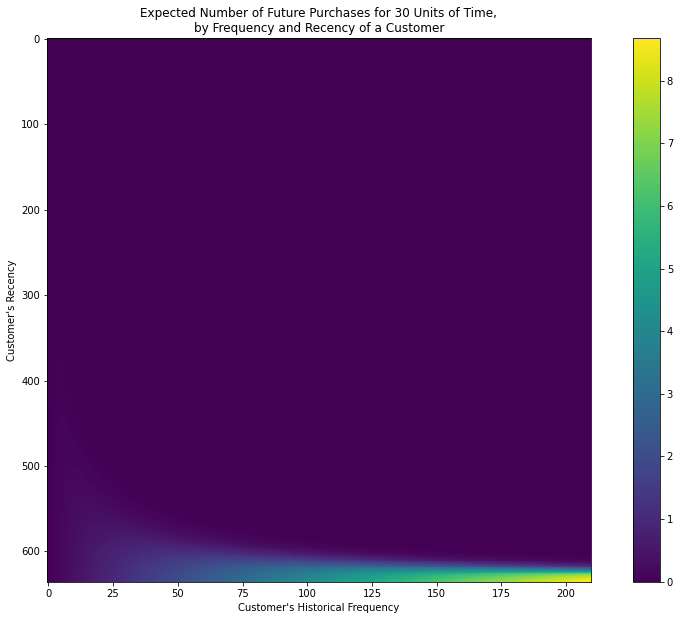

In [44]:
plt.figure(figsize=(15,10))
plot_frequency_recency_matrix(bgf, T=30)

### Probabilidade de um Cliente estar vivo

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

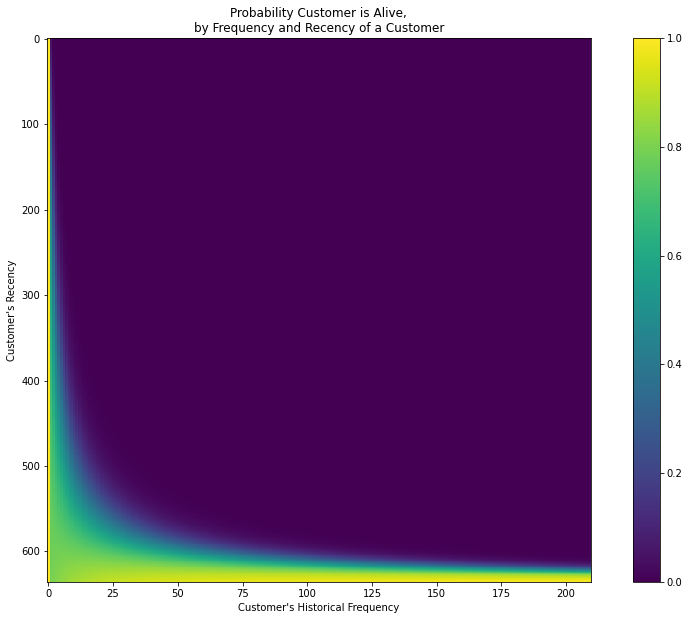

In [45]:
plt.figure(figsize=(15,10))
plot_probability_alive_matrix(bgf)

### Previsão de número de pedidos para daqui a 30 dias

In [46]:
t = 30
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,customer_id,frequency,T,recency,monetary_value,predicted_purchases
1822,14871.0,3.0,622.695364,357.0,130.5950,0.065261
1405,14293.0,3.0,630.695364,365.0,261.6400,0.065545
4002,17884.0,3.0,633.695364,368.0,179.3625,0.065642
3037,16539.0,3.0,635.695364,371.0,347.2025,0.066022
531,13077.0,3.0,628.695364,365.0,182.3175,0.066129


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 1080x720 with 0 Axes>

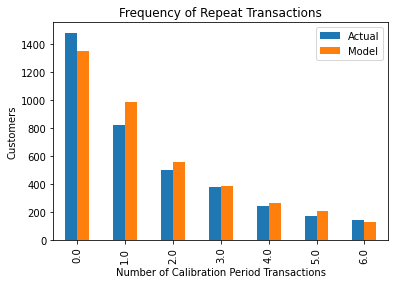

In [47]:
plt.figure(figsize=(15,10))
plot_period_transactions(bgf)

### Usando os dados transacionais para prever clientes individualmente

In [48]:
transaction_data = df_clean.groupby(['customer_id', 'date']).sum().reset_index()
transaction_data = transaction_data[['customer_id', 'date', 'total_value']]

In [49]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_id', 'date',
                                        calibration_period_end=transaction_data['date'].max().value-180,
                                        observation_period_end=transaction_data['date'].max().value)
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
12346.0,0.0,0.0,324.0,0.0,1.0
12347.0,6.0,365.0,366.0,0.0,1.0
12349.0,0.0,0.0,17.0,0.0,1.0
12350.0,0.0,0.0,309.0,0.0,1.0
12352.0,6.0,260.0,295.0,0.0,1.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

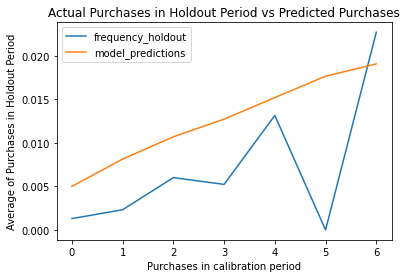

In [50]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Ajustando o modelo para prever a probabilidade de um cliente estar "Vivo" no futuro

In [51]:
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 4297 subjects, a: 3.76, alpha: 24.10, b: 14.53, r: 0.38>

### Listando os clientes de maior frequencia

In [52]:
data.sort_values('frequency', ascending=False).head()

,customer_id,frequency,T,recency,monetary_value,predicted_purchases
304,12748.0,209.0,635.695364,373.0,160.570143,3.526959e-44
3970,17841.0,123.0,635.695364,372.0,330.577177,8.625206e-26
539,13089.0,96.0,631.695364,367.0,606.451856,2.769297e-20
1633,14606.0,92.0,635.695364,372.0,130.716667,3.708052e-19
2139,15311.0,90.0,635.695364,373.0,667.779121,1.240528e-18


In [53]:
t = 1
id = 12748.0

individual = data.loc[data['customer_id'] == id]

bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

304    1.266453e-45
dtype: float64

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

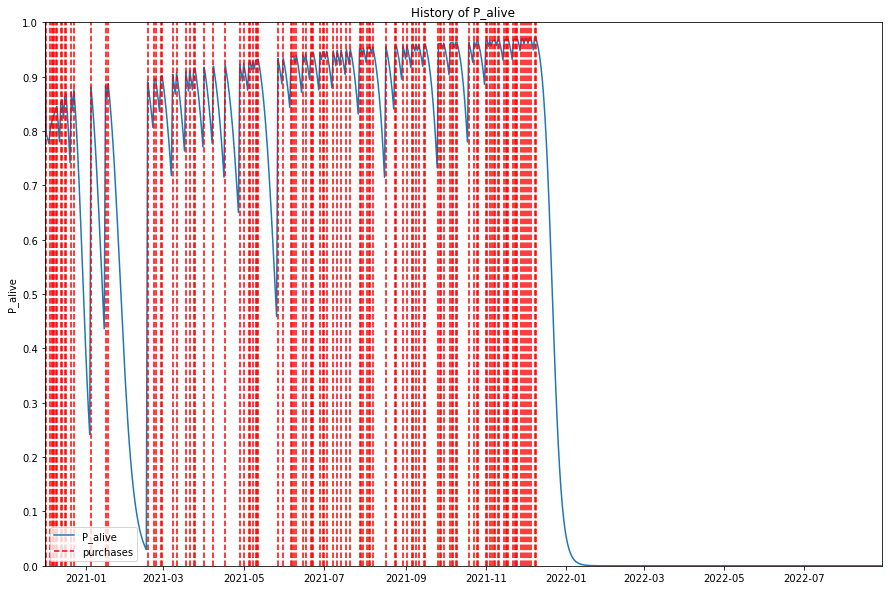

In [54]:
sp_trans = transaction_data.loc[transaction_data['customer_id'] == id]
days_since_birth = round((pd.Timestamp.now()-sp_trans.min()[1])/np.timedelta64(1,'D'))
plt.figure(figsize=(15,10))
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

### Listando os clientes com menor frequencia (maiores que zero)

In [55]:
data.loc[data['frequency']>1].sort_values('frequency', ascending=True).head()

,customer_id,frequency,T,recency,monetary_value,predicted_purchases
2153,15329.0,2.0,433.695364,132.0,349.900000,0.036967
2047,15192.0,2.0,627.695364,246.0,348.106667,0.036349
2051,15197.0,2.0,620.695364,348.0,359.870000,0.057556
2065,15215.0,2.0,358.695364,50.0,244.980000,0.013944
2084,15238.0,2.0,446.695364,155.0,357.330000,0.043532


In [56]:
t = 30
id = 15329.0

individual = data.loc[data['customer_id'] == id]

bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

2153    0.036967
dtype: float64

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

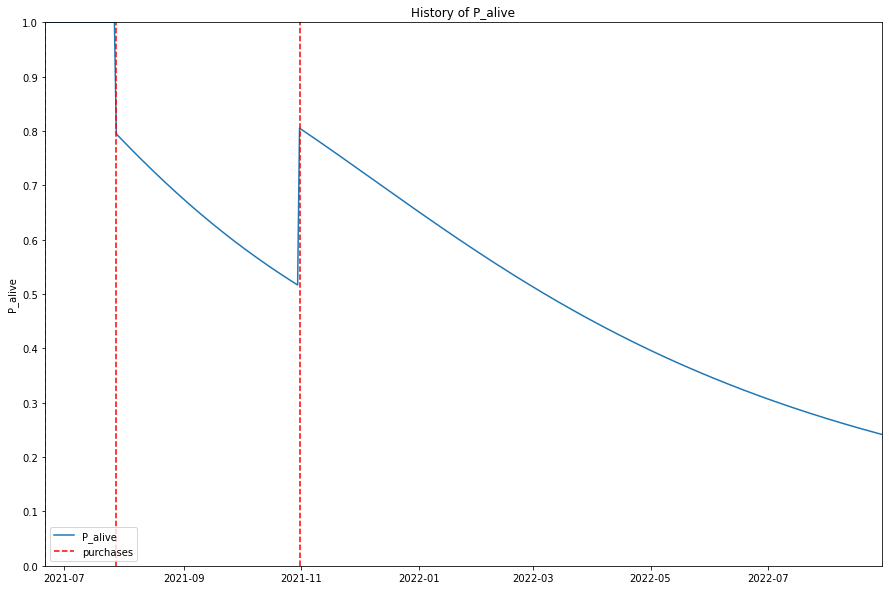

In [57]:
sp_trans = transaction_data.loc[transaction_data['customer_id'] == id]
days_since_birth = round((pd.Timestamp.now()-sp_trans.min()[1])/np.timedelta64(1,'D'))
plt.figure(figsize=(15,10))
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

### Estimativa do valor do cliente usando modelo Gama-Gama

O paper que suporta estes cálculos pode ser encontrado neste link: http://www.brucehardie.com/notes/025/gamma_gamma.pdf

In [58]:
returning_customers_summary = data[data['frequency']>0]

### O modelo gamma-gamma assume que não existe uma correlação entre o gasto médio e o número de pedidos, portanto vamos checar a correlação de pearson para ver se esse valor está próximo de zero

In [59]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.025322
frequency,0.025322,1.000000


In [60]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2816 subjects, p: 3.34, q: 3.61, v: 301.64>


In [61]:
data['avg_spent'] = ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    )

data.head(10)

,customer_id,frequency,T,recency,monetary_value,predicted_purchases,avg_spent
0,12346.0,0.0,587.695364,0.0,77183.600000,0.018486,385.826420
1,12347.0,6.0,629.695364,365.0,615.714286,0.045440,589.213093
2,12349.0,0.0,280.695364,0.0,1757.550000,0.036851,385.826420
3,12350.0,0.0,572.695364,0.0,334.400000,0.018947,385.826420
4,12352.0,7.0,558.695364,260.0,313.255000,0.009741,320.545879
5,12353.0,0.0,466.695364,0.0,89.000000,0.023004,385.826420
6,12354.0,0.0,494.695364,0.0,1079.400000,0.021773,385.826420
7,12355.0,0.0,476.695364,0.0,459.400000,0.022549,385.826420
8,12356.0,2.0,587.695364,303.0,937.143333,0.055397,782.201027
9,12357.0,0.0,295.695364,0.0,6207.670000,0.035145,385.826420


In [62]:
data['clv'] = ggf.customer_lifetime_value(
    bgf, # mesmo modelo utilizado para prever pedidos futuros
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # número de meses à frente
    discount_rate=0.1 # taxa de desconto mensal
)

data.head(10)

,customer_id,frequency,T,recency,monetary_value,predicted_purchases,avg_spent,clv
0,12346.0,0.0,587.695364,0.0,77183.600000,0.018486,385.826420,45.911989
1,12347.0,6.0,629.695364,365.0,615.714286,0.045440,589.213093,149.117248
2,12349.0,0.0,280.695364,0.0,1757.550000,0.036851,385.826420,87.034965
3,12350.0,0.0,572.695364,0.0,334.400000,0.018947,385.826420,46.995199
4,12352.0,7.0,558.695364,260.0,313.255000,0.009741,320.545879,16.718217
5,12353.0,0.0,466.695364,0.0,89.000000,0.023004,385.826420,56.403094
6,12354.0,0.0,494.695364,0.0,1079.400000,0.021773,385.826420,53.569428
7,12355.0,0.0,476.695364,0.0,459.400000,0.022549,385.826420,55.357205
8,12356.0,2.0,587.695364,303.0,937.143333,0.055397,782.201027,261.303440
9,12357.0,0.0,295.695364,0.0,6207.670000,0.035145,385.826420,83.376202


### Por fim, podemos juntar as estimativas do lifetimes com a segmentação do k-means e ver se os dados fazem sentido

In [63]:
customer_clusters = customers[['customer_id'
                               , 'OverallScore'
                               , 'recency_cluster'
                               , 'average_time_between_orders_cluster'
                               , 'average_ticket_cluster'
                               , 'transactions_cluster']]

In [64]:
final_dataset = pd.merge(data, customer_clusters, on='customer_id', how='inner')

In [65]:
def final_agg(x):
    names = {
          'customers': x['customer_id'].nunique()
        , 'frequency': x['frequency'].mean()
        , 'T': x['T'].mean() 
        , 'recency': x['recency'].mean()
        , 'monetary_value': (x['monetary_value']*x['frequency']).sum()/x['frequency'].sum()
        , 'avg_spent':  (x['avg_spent']*x['frequency']).sum()/x['frequency'].sum()
        , 'clv': x['clv'].mean()
        , 'predicted_purchases': x['predicted_purchases'].mean()
    }
    return pd.Series(names, index=[
                                    'customers'
                                  , 'frequency'
                                  , 'T'
                                  , 'recency'
                                  , 'monetary_value'
                                  , 'avg_spent'
                                  , 'clv'
                                  , 'predicted_purchases'
                                  ])

In [66]:
final_dataset_agg = final_dataset.groupby('OverallScore').apply(final_agg)

In [67]:
final_dataset_agg

,customers,frequency,T,recency,monetary_value,avg_spent,clv,predicted_purchases
OverallScore,,,,,,,,
0,510.0,0.023529,560.199285,0.000000,224.043750,295.028961,4.720025e+01,1.908268e-02
1,463.0,0.380130,464.192124,13.462203,633.825509,561.630910,5.178217e+01,2.089577e-02
2,1091.0,0.780935,398.594539,50.747938,325.422006,341.869567,6.486043e+01,2.809426e-02
3,1559.0,2.534958,484.370155,187.819115,374.503527,378.207997,7.826295e+01,3.574862e-02
4,582.0,9.525773,582.274402,300.780069,442.023412,433.361751,4.882771e+01,1.186540e-02
5,85.0,30.141176,619.283599,350.741176,766.957612,759.135202,6.430989e-02,3.048008e-05
6,7.0,109.714286,632.266792,368.428571,640.683375,637.550672,2.125679e-12,1.348390e-16


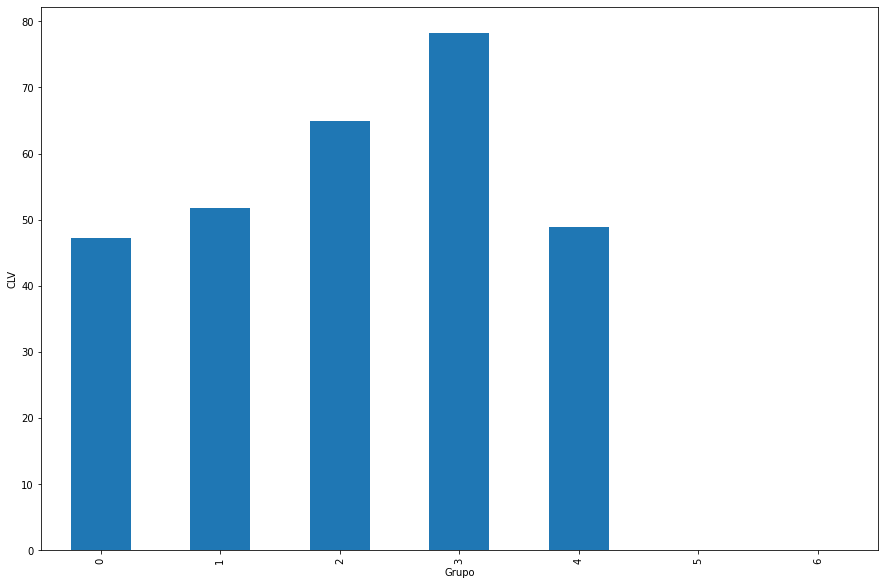

In [68]:
plt.figure(figsize=(15,10))
final_dataset_agg['clv'].plot(kind='bar')
plt.xlabel('Grupo')
plt.ylabel('CLV')
plt.show()

### Inspecionando porque os grupos 5 e 6 ficaram com um CLV muito baixo

In [69]:
final_dataset[final_dataset['OverallScore']>4]

,customer_id,frequency,T,recency,monetary_value,predicted_purchases,avg_spent,clv,OverallScore,recency_cluster,average_time_between_orders_cluster,average_ticket_cluster,transactions_cluster
44,12415.0,20.0,599.695364,313.0,5948.310952,2.970388e-05,5739.053999,8.120826e-01,5,2,1,0,2
86,12471.0,29.0,626.695364,362.0,660.801667,3.161065e-06,653.583334,9.546976e-03,5,2,1,0,2
163,12569.0,31.0,514.695364,250.0,128.896563,1.192008e-08,135.216755,6.944492e-06,5,2,1,0,2
251,12681.0,21.0,629.695364,353.0,626.706364,6.671813e-05,618.060645,1.979445e-01,5,2,1,0,2
252,12682.0,30.0,633.695364,368.0,396.394194,2.266492e-06,396.125793,4.147470e-03,5,2,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4061,17961.0,38.0,634.695364,351.0,33.242051,9.248813e-09,40.349755,1.684018e-06,5,2,1,0,2
4116,18041.0,20.0,634.695364,361.0,199.209048,1.397155e-04,206.229469,1.394173e-01,5,2,1,0,2
4160,18102.0,59.0,629.695364,367.0,4327.621667,2.762348e-12,4276.072781,5.119585e-08,5,2,1,0,2
4165,18109.0,25.0,631.695364,368.0,309.729615,2.420979e-05,312.037146,3.556965e-02,5,2,1,0,2


### Podemos notar que a previsão de compras futuras é bem baixa. Isso se deve ao fato de que, como estes clientes possuiam uma frequência de compra muito alta, um tempo pequeno sem comprar é um indício de que este cliente já não está mais "vivo"
### De toda forma, neste caso, por serem clientes que possuiam alto gasto médio e alta frequência, poderíamos pensar em formas de recuperá-los, assim como podemos definir ações especificas para cada um dos demais grupos para mover os clientes cada vez mais acima na classificação